In [1]:
import pandas as pd
import re
import csv

pd.set_option('display.max_colwidth', None)


def load(filename):
    df = pd.read_csv(filename, sep='\t', encoding='utf-8', names=['tweet_id', 'tweet_url', 'tweet_text', 'class_label'], quoting=csv.QUOTE_NONE, skiprows=1)
    df.drop(columns=['tweet_url'], inplace=True)
    return df


train_df = load('CT24_checkworthy_spanish_train.tsv')
dev_df = load('CT24_checkworthy_spanish_dev.tsv')
dev_test_df =  load('CT24_checkworthy_spanish_dev-test.tsv')

## Data exploration
* Dataframe size
* Class distributation
* Text Length Analysis
* Word Frequency Analysis
* Check for emojies and special chars
* Find and print filler words
* Find and save hashtags and mentions
* Find dublicates


In [2]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00


Dataset Size:
(19990, 3)

Class Distribution:
class_label
No     16862
Yes     3128
Name: count, dtype: int64
Text Length Statistics:
 count    19990.000000
mean        26.035218
std         15.947757
min          1.000000
25%         12.000000
50%         25.000000
75%         40.000000
max        182.000000
Name: text_length, dtype: float64


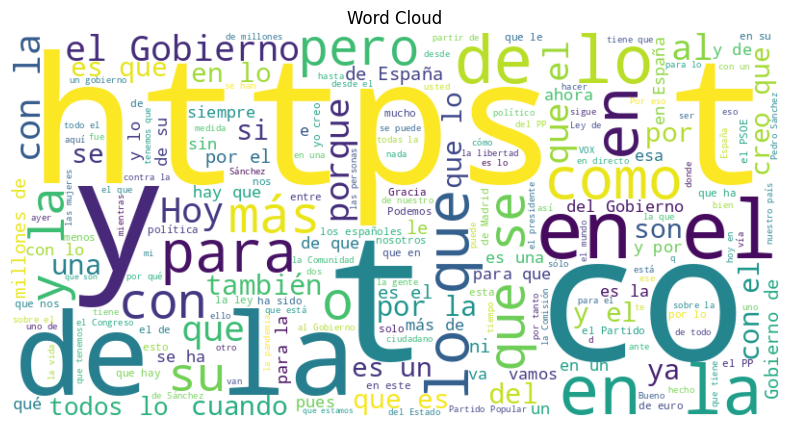

Most Common Hashtags:
 PGE2022               72
Avanzamos_            71
SoloQuedaVox          56
ActualidadCs          55
CMin                  34
COVID19               33
NiUnaMenos            32
EspañaSiempre         29
PorTodoLoQueNosUne    26
España                26
Name: count, dtype: int64
Most Common Mentions:
 populares          149
sanchezcastejon    145
pablocasado_       142
Congreso_Es        142
GPPopular          126
PSOE               111
gpscongreso        105
vox_es              77
Hectorgomezh        60
el_pais             52
Name: count, dtype: int64


,tweet_id,tweet_text,class_label,text_length,clean_text,sentiment,hashtags,mentions
0,1192517071348699136,"📅 Mañana, viernes, no puedes perderte el gran acto de cierre de campaña en Madrid. ⏰ A las 19.00 h en el Pabellón 1 de IFEMA (Madrid). Con Kiko Veneno y O'Funk'illo en concierto y la intervención de @Pablo_Iglesias_, @AdaColau, @Irene_Montero_, @agarzon... ¡Te esperamos! https://t.co/IxHyDWdB0S",No,45,"📅 Mañana, viernes, no puedes perderte el gran acto de cierre de campaña en Madrid. ⏰ A las 19.00 h en el Pabellón 1 de IFEMA (Madrid). Con Kiko Veneno y O'Funk'illo en concierto y la intervención de , , , ... ¡Te esperamos! https://t.co/IxHyDWdB0S",-0.5983,[],"[Pablo_Iglesias_,, AdaColau,, Irene_Montero_,, agarzon...]"
1,1220987059701190656,"🔴 DIRECTO | Reyes Maroto: ""Si nos centramos en las sinergias la legislatura, al menos en la parte del gobierno, va a funcionar muy bien. Además, los ministros y ministras nos llevamos muy bien"" https://t.co/K3k4v7vslz",No,35,"🔴 DIRECTO | Reyes Maroto: ""Si nos centramos en las sinergias la legislatura, al menos en la parte del gobierno, va a funcionar muy bien. Además, los ministros y ministras nos llevamos muy bien"" https://t.co/K3k4v7vslz",0.0000,[],[]
2,1226786513226280961,"@JonInarritu @EHBilduCongreso 🔴🎙️ @JonInarritu, diputado @EHBilduCongreso: ""Que los partidos catalanes nacionalistas encuentren un Mínimo Común Denominador es difícil. Sobre todo, si se intentan sembrar la discordia y si la represión provoca un adelanto electoral.""",No,34,"🔴🎙️ , diputado : ""Que los partidos catalanes nacionalistas encuentren un Mínimo Común Denominador es difícil. Sobre todo, si se intentan sembrar la discordia y si la represión provoca un adelanto electoral.""",0.0000,[],"[JonInarritu, EHBilduCongreso, JonInarritu,, EHBilduCongreso:]"
3,1217566329823252481,@tve_tve vuelve a quedar en evidencia. Desplaza al minuto 18 la denuncia del #CGPJ ante las críticas de Iglesias y habla de “diferencias”. Exigimos al responsable de edición del telediario explicaciones y a Sánchez que deje de utilizar @rtve a su antojo @Enric_Hernandez,Yes,43,vuelve a quedar en evidencia. Desplaza al minuto 18 la denuncia del #CGPJ ante las críticas de Iglesias y habla de “diferencias”. Exigimos al responsable de edición del telediario explicaciones y a Sánchez que deje de utilizar a su antojo,0.0000,[CGPJ],"[tve_tve, rtve, Enric_Hernandez]"
4,1172059020095610881,"El nuevo curso escolar en #Andalucía comienza con... ?? ✅El mayor presupuesto de su historia ✅750 nuevos profesores, más que nunca ✅3.000 nuevos funcionarios que antes eran interinos Son hechos: la oposición miente cuando dice que estamos desmantelando la educación pública. https://t.co/c8fANaDaRA",Yes,42,"El nuevo curso escolar en #Andalucía comienza con... ?? ✅El mayor presupuesto de su historia ✅750 nuevos profesores, más que nunca ✅3.000 nuevos funcionarios que antes eran interinos Son hechos: la oposición miente cuando dice que estamos desmantelando la educación pública. https://t.co/c8fANaDaRA",0.0000,[Andalucía],[]


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import html
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


filler_words = ['eh', 'ah', 'oh', 'pues', 'bueno', 'vaya', 'oye', 'mira', 'entonces', 'a ver']
html_replace = {
        '&lt;': '<',
        '&gt;': '>',
        '&amp;': '&',
        '&quot;': '"',
        '&apos;': "'",
        '&#39;': "'",
        '&#34;': '"',
        '&#60;': '<',
        '&#62;': '>',
        '&#38;': '&'
    }

def replace_html_entities(text):
    # Replace common HTML entities
    text = html.unescape(text)
    for entity, char in html_replace.items():
        text = text.replace(entity, char)
    return text

def find_fillers(text):
    words = text.lower().split()
    found_fillers = [word for word in words if word in filler_words]
    return found_fillers

# Function to analyze sentiment using VADER
def analyze_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Function to categorize sentiment score
def categorize_sentiment(score):
    bins = [-1, -0.25, 0, 0.25, 0.5, 0.75, 1]
    labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'extremely_positive']
    return pd.cut([score], bins=bins, labels=labels)[0]

def symmentic_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    return text


def data_exploration(df):
  print("Dataset Size:")
  print(df.shape)

  print("\nClass Distribution:")
  print(df['class_label'].value_counts())

  # Text length analysis
  df['text_length'] = df['tweet_text'].apply(lambda x: len(x.split()))
  print("Text Length Statistics:\n", df['text_length'].describe())

  # Word Frequency Analysis
  all_words = ' '.join(df['tweet_text'])
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud')
  plt.show()

  # Apply preprocessing for sentiment
  df['clean_text'] = df['tweet_text'].apply(symmentic_text)
  # Analyze sentiment using VADER
  df['sentiment'] = df['clean_text'].apply(analyze_sentiment_vader)

  # Hashtag and Mention Analysis
  df['hashtags'] = df['tweet_text'].apply(lambda x: [word[1:] for word in x.split() if word.startswith('#')])
  print("Most Common Hashtags:\n", pd.Series([item for sublist in df['hashtags'] for item in sublist]).value_counts().head(10))

  df['mentions'] = df['tweet_text'].apply(lambda x: [word[1:] for word in x.split() if word.startswith('@')])
  print("Most Common Mentions:\n", pd.Series([item for sublist in df['mentions'] for item in sublist]).value_counts().head(10))

  return


data_exploration(train_df)
train_df.head()


In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

def remove_extra_spaces(text):
    # Remove additional white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def replace_text(text):
  text = re.sub(r'’', '" ', text)
  text = re.sub(r'“', '" ', text)
  text = re.sub(r'”', '" ', text)

  # Replace euro symbol with text and format amount
  text = re.sub(r'€(\d+)', r'euro \1', text)
  text = re.sub(r'(\d+)\s*M€', r'\1 millones de euros', text) # Replace M€
  text = re.sub(r'\[.*?\]', '.', text) # Remove [] and its content

  # Remove special characters at the start of the text
  if text.startswith('?| ') or text.startswith('? | '):
        text = text.lstrip('?| ')
        text = text.lstrip('? | ')

    # Remove special characters at the end of the text
  if text.endswith(' |') or text.endswith('| '):
        text = text.rstrip(' |')
        text = text.rstrip('| ')

    # Replace ' ? ' with ' '
  if ' ? ' in text:
        text = text.replace(' ? ', ' ')

    # Replace ' | ' with ' '
  if ' | ' in text:
        text = text.replace(' | ', ' ')

    # Replace : with .
  if text.endswith(':'):
        text = text[:-1] + '.'

  return text

def handle_dash(text):
    # Replace "/" between two related pieces of information with "o"
    text = re.sub(r'(\w+)\s*/\s*(\w+)', r'\1 o \2', text)

    # Remove "/" at the end or before a dot
    text = re.sub(r'(/|\./)\s*', '', text)
    return text

def clean_text(text):
  text = re.sub(r'(@\w+\s*)+', '@<USER> ', text)

  text = re.sub(r'[^\x00-\x7Fáéíóúüñ¡¿]+', '', text) # Remove emojis and non-ASCII characters excluding Spanish special characters
  text = re.sub(r'http\S+|www.\S+', '', text).strip()  # Remove urls
  text = re.sub(r'\? @', ' @', text) # Replace "?" before mentions with space
  text = re.sub(r'->|�', ' ', text) # Replace special characters

  return text

def replace_repeated_characters(text):
    # Replace repeated special characters with a single occurrence
    text = re.sub(r'([,!?]){2,}', r'\1', text)
    text = re.sub(r'\.{4,}', '...', text)
    return text

def remove_repetitive_phrases(text):
    # Split text into tokens
    tokens = re.split(r'[ ,]+', text)

    # Remove duplicates while preserving order
    unique_tokens = []
    seen_tokens = set()

    for token in tokens:
        if token not in seen_tokens:
            unique_tokens.append(token)
            seen_tokens.add(token)

    # Join unique tokens back into a string
    cleaned_text = ' '.join(unique_tokens)

    return cleaned_text

def preprocessing(train_df):
  train_df['tweet_text'] = train_df['tweet_text'].apply(replace_html_entities)
  train_df['tweet_text'] = train_df['tweet_text'].apply(replace_repeated_characters)
  train_df['tweet_text'] = train_df['tweet_text'].apply(clean_text)

  train_df['tweet_text'] = train_df['tweet_text'].apply(replace_text)
  train_df['tweet_text'] = train_df['tweet_text'].apply(handle_dash)

  train_df['tweet_text'] = train_df['tweet_text'].apply(remove_repetitive_phrases)

  train_df['tweet_text'] = train_df['tweet_text'].apply(remove_extra_spaces)

  # Sentiment polarity category
  train_df['sentiment_category'] = train_df['sentiment'].apply(categorize_sentiment)


  # Categorize text length
  bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
  labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '100+']
  train_df['text_length_category'] = pd.cut(train_df['text_length'], bins=bins, labels=labels)

  # Label encode class label
  label_encoder = LabelEncoder()
  train_df['class_label_encoded'] = label_encoder.fit_transform(train_df['class_label'])


  train_df = train_df.drop(columns=['text_length', 'clean_text', 'sentiment'])
  return train_df


train_df = preprocessing(train_df)
train_df.head()

,tweet_id,tweet_text,class_label,hashtags,mentions,sentiment_category,text_length_category,class_label_encoded
0,1192517071348699136,Mañana viernes no puedes perderte el gran acto de cierre campaña en Madrid. A las 19.00 h Pabellón 1 IFEMA (Madrid). Con Kiko Veneno y O'Funk'illo concierto la intervención @<USER> ... ¡Te esperamos!,No,[],"[Pablo_Iglesias_,, AdaColau,, Irene_Montero_,, agarzon...]",very_negative,41-50,0
1,1220987059701190656,"DIRECTO Reyes Maroto: ""Si nos centramos en las sinergias la legislatura al menos parte del gobierno va a funcionar muy bien. Además los ministros y ministras llevamos bien""",No,[],[],negative,31-40,0
2,1226786513226280961,"@<USER> diputado : ""Que los partidos catalanes nacionalistas encuentren un Mínimo Común Denominador es difícil. Sobre todo si se intentan sembrar la discordia y represión provoca adelanto electoral.""",No,[],"[JonInarritu, EHBilduCongreso, JonInarritu,, EHBilduCongreso:]",negative,31-40,0
3,1217566329823252481,@<USER> vuelve a quedar en evidencia. Desplaza al minuto 18 la denuncia del #CGPJ ante las críticas de Iglesias y habla diferencias. Exigimos responsable edición telediario explicaciones Sánchez que deje utilizar su antojo,Yes,[CGPJ],"[tve_tve, rtve, Enric_Hernandez]",negative,41-50,1
4,1172059020095610881,El nuevo curso escolar en #Andalucía comienza con... mayor presupuesto de su historia 750 nuevos profesores más que nunca 3.000 funcionarios antes eran interinos Son hechos: la oposición miente cuando dice estamos desmantelando educación pública.,Yes,[Andalucía],[],negative,41-50,1


## Feature engineering
  * Add Frequency of Hashtags
  * Sentiment Analysis of Hashtags
  * Topic Modeling with LDA

###Changes Made:

    Preprocessing: tweet_text is preprocessed into clean_text and used for topic modeling with LDA.

    Sentiment Analysis: TextBlob's sentiment analysis for hashtags remains the same to handle Dutch tweets more accurately.

    Topic Modeling: clean_text is used for topic modeling with LDA.

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import DutchStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download Spanish stop words
nltk.download('stopwords')
spanish_stop_words = list(stopwords.words('spanish'))

# Function to count frequency of hashtags
def count_hashtags_frequency(hashtags_list):
    return len(hashtags_list)

# Function to analyze sentiment of hashtags
def analyze_hashtag_sentiment(hashtags_list):
    if hashtags_list:
        sentiment_scores = [TextBlob(hashtag).sentiment.polarity for hashtag in hashtags_list]
        avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        return avg_sentiment
    else:
        return 0

# Function for topic modeling with LDA
def topic_modeling_with_lda(texts):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=spanish_stop_words)
    dtm = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    topics = lda.transform(dtm)

    return topics.argmax(axis=1)


def add_additional_features(train_df):
    # Count frequency of hashtags
    train_df['hashtags_frequency'] = train_df['hashtags'].apply(count_hashtags_frequency)

    # Analyze sentiment of hashtags
    train_df['hashtags_sentiment'] = train_df['hashtags'].apply(analyze_hashtag_sentiment)

    # Topic modeling with LDA using tweet_text
    train_df['hashtags_topics'] = topic_modeling_with_lda(train_df['tweet_text'])

    return train_df

train_df = add_additional_features(train_df)
train_df.head(4)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweet_id,tweet_text,class_label,hashtags,mentions,sentiment_category,text_length_category,class_label_encoded,hashtags_frequency,hashtags_sentiment,hashtags_topics
0,1192517071348699136,Mañana viernes no puedes perderte el gran acto de cierre campaña en Madrid. A las 19.00 h Pabellón 1 IFEMA (Madrid). Con Kiko Veneno y O'Funk'illo concierto la intervención @<USER> ... ¡Te esperamos!,No,[],"[Pablo_Iglesias_,, AdaColau,, Irene_Montero_,, agarzon...]",very_negative,41-50,0,0,0.0,0
1,1220987059701190656,"DIRECTO Reyes Maroto: ""Si nos centramos en las sinergias la legislatura al menos parte del gobierno va a funcionar muy bien. Además los ministros y ministras llevamos bien""",No,[],[],negative,31-40,0,0,0.0,4
2,1226786513226280961,"@<USER> diputado : ""Que los partidos catalanes nacionalistas encuentren un Mínimo Común Denominador es difícil. Sobre todo si se intentan sembrar la discordia y represión provoca adelanto electoral.""",No,[],"[JonInarritu, EHBilduCongreso, JonInarritu,, EHBilduCongreso:]",negative,31-40,0,0,0.0,2
3,1217566329823252481,@<USER> vuelve a quedar en evidencia. Desplaza al minuto 18 la denuncia del #CGPJ ante las críticas de Iglesias y habla diferencias. Exigimos responsable edición telediario explicaciones Sánchez que deje utilizar su antojo,Yes,[CGPJ],"[tve_tve, rtve, Enric_Hernandez]",negative,41-50,1,1,0.0,2


## Saving Preprocessing

Dataset Size:
(5000, 3)

Class Distribution:
class_label
No     4296
Yes     704
Name: count, dtype: int64
Text Length Statistics:
 count    5000.000000
mean       30.623400
std        12.891998
min         1.000000
25%        19.000000
50%        33.000000
75%        42.000000
max        56.000000
Name: text_length, dtype: float64


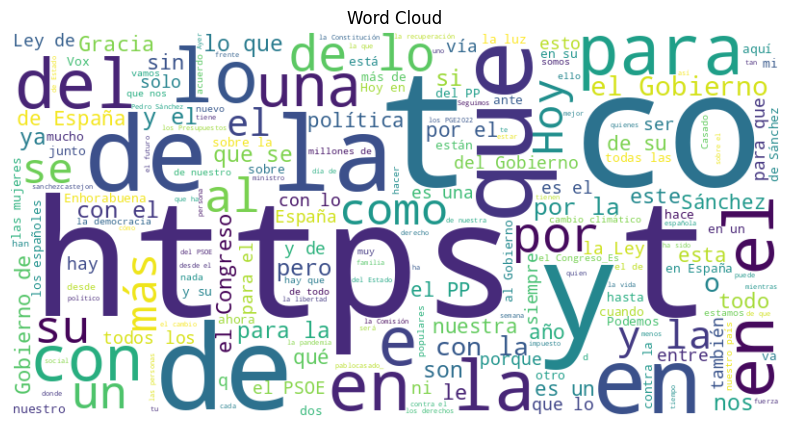

Most Common Hashtags:
 PGE2022           83
Avanzamos_        70
SoloQuedaVox      54
COP26             30
40CongresoPSOE    19
Creemos           18
Ávila             17
Álava             16
25N               16
EspañaAvanza_     15
Name: count, dtype: int64
Most Common Mentions:
 Congreso_Es        132
GPPopular          112
sanchezcastejon    104
populares          101
gpscongreso         96
PSOE                93
pablocasado_        81
Hectorgomezh        59
socialistes_cat     42
vox_es              38
Name: count, dtype: int64
Dataset Size:
(5000, 3)

Class Distribution:
class_label
No     4491
Yes     509
Name: count, dtype: int64
Text Length Statistics:
 count    5000.000000
mean       23.856200
std        16.050416
min         1.000000
25%        10.000000
50%        21.000000
75%        37.000000
max       151.000000
Name: text_length, dtype: float64


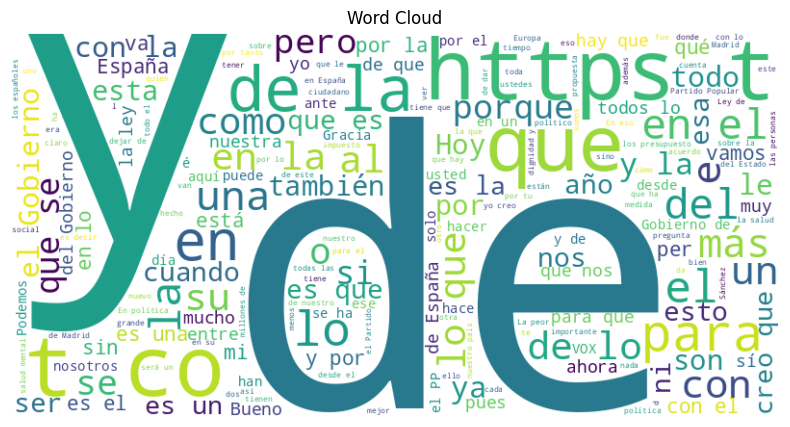

Most Common Hashtags:
 VIVA22                       39
PGE2023                      32
ActualidadCs                 22
DíaMundialdelaSaludMental    17
EspañaDecide                 13
CMin                         13
DiaMundialdelaSaludMental    13
ElGobiernoDeLaGente          12
ConquistandoDerechos         12
SánchezHipoteca              11
Name: count, dtype: int64
Most Common Mentions:
 Santi_ABASCAL      24
jorditurull        20
sanchezcastejon    19
NunezFeijoo        19
InesArrimadas      19
ElensGuitart       19
vox_es             19
IreneMontero       16
Ortega_Smith       15
rubenmansolivar    15
Name: count, dtype: int64


In [6]:
import csv

def preprocess_dev_data(df):
    data_exploration(df)
    df = preprocessing(df)
    df = add_additional_features(df)
    return df

def save_processed_dev_data(df, filepath):
    df.to_csv(filepath, sep='\t', index=False, quoting=csv.QUOTE_NONE)

#'CT24_checkworthy_spanish/CT24_checkworthy_spanish_dev.tsv'
dev = preprocess_dev_data(dev_df)
#'CT24_checkworthy_spanish/CT24_checkworthy_spanish_dev-test.tsv'
dev_test = preprocess_dev_data(dev_test_df)

save_processed_dev_data(dev, 'processed_spanish_dev.tsv')
save_processed_dev_data(dev_test, 'processed_spanish_dev_test.tsv')
save_processed_dev_data(train_df, 'processed_spanish_train.tsv')
